In [60]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt



def gaussian_kernel(x):
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# Step 1: Define the polynomial perturbation ξ(t)
def xi_poly(t, coeffs):
    return sum(c * t**i for i, c in enumerate(coeffs))

# Step 2: Define f_u_hat = u_hat - ξ(t)
def f_u_hat(u_hat_vals, t_vals, coeffs):
    return u_hat_vals - xi_poly(t_vals, coeffs)

# Step 3: Objective function: mean squared error between w_j and f_u_hat(x_j)
def mse_loss(coeffs, x_raw, w_raw, t_vals, u_hat_interp):
    xi_vals = xi_poly(x_raw, coeffs)
    f_vals = u_hat_interp(x_raw) - xi_vals
    return np.mean((w_raw - f_vals)**2)

# Optional: Smooth interpolator for u_hat (use linear interpolation)
def optimize_fractal_perturbation(x_raw, w_raw, t_vals, u_hat_vals, p=2):
    # Interpolate u_hat so we can evaluate at any x_raw point
    u_hat_interp = interp1d(t_vals, u_hat_vals, kind='linear', fill_value="extrapolate")

    # Initial guess for coeffs c0, c1, ..., cp
    init_coeffs = np.zeros(p + 1)

    # Minimize MSE using SLSQP
    res = minimize(mse_loss, init_coeffs, args=(x_raw, w_raw, t_vals, u_hat_interp),
                   method='SLSQP')

    return res.x, res.fun  # optimal coeffs, final loss


def priestley_chao_estimator(x, z, d=0.05, num_points=500):
    """Compute the Priestley-Chao estimator u_hat(t)."""
    N = len(x) - 1
    t_vals = np.linspace(0, 1, num_points)
    u_hat = np.zeros_like(t_vals)

    for idx, t in enumerate(t_vals):
        sum_val = 0.0
        for i in range(N + 1):
            weight = gaussian_kernel((t - x[i]) / d) / d
            sum_val += (z[i]) * weight
        u_hat[idx] = sum_val / (N * np.sqrt(2 * np.pi))
    
    return t_vals, u_hat




def plot_comparison(x_raw, w_raw, t_vals, u_hat_vals, coeffs):
    u_hat_interp = interp1d(t_vals, u_hat_vals, kind='linear', fill_value="extrapolate")
    xi_vals = xi_poly(x_raw, coeffs)
    f_vals = u_hat_interp(x_raw) - xi_vals

    plt.figure(figsize=(10, 5))
    plt.plot(x_raw, w_raw,'--', label='Raw Data', alpha=0.6)
    plt.plot(x_raw, f_vals, label='PC Estimator', linewidth=2)
    plt.legend()
    plt.title(' PC Estimator With Fractal Perturbation')
    plt.xlabel('Normalized Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()


In [61]:
import pandas as pd
import numpy as np

# Load your DataFrame (assuming it's already loaded into `df`)
# Reverse the data so time increases from past to recent
df = pd.read_csv("Crude Oil WTI Futures Historical Data.csv")
df = df.iloc[::-1].reset_index(drop=True)

# Normalize time to [0, 1]
x_raw = np.linspace(0, 1, len(df))
w_raw = df["Price"].astype(float).values  # ensure float type


# Sample indices at t = 0.0, 0.1, ..., 1.0
sample_indices = np.linspace(0, len(x_raw)-1, 11, dtype=int)
x_sample = x_raw[sample_indices]
z_sample = w_raw[sample_indices]


d=0.0513

t_vals, u_hat_vals = priestley_chao_estimator(x_sample, z_sample, d, num_points=500)


In [62]:
# Choose polynomial degree p (e.g. p = 2 or 3)
optimal_coeffs, final_loss = optimize_fractal_perturbation(
    x_raw, w_raw, t_vals, u_hat_vals, p=2
)

print("Final MSE loss:", final_loss)


Final MSE loss: 35.79683207279462


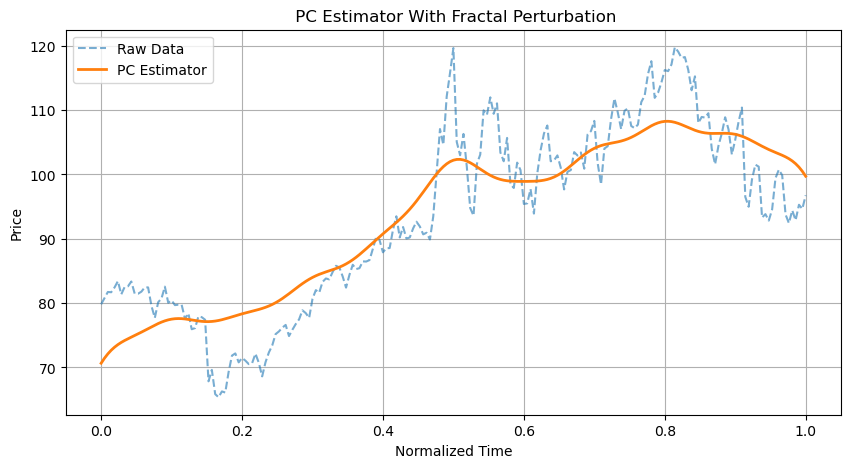

In [63]:
plot_comparison(x_raw, w_raw, t_vals, u_hat_vals, optimal_coeffs)


In [64]:
def nadaraya_watson_estimator(x, z, d=0.05, num_points=500):
    """Compute the Nadaraya-Watson estimator u_hat(t)."""
    t_vals = np.linspace(0, 1, num_points)
    u_hat = np.zeros_like(t_vals)

    for idx, t in enumerate(t_vals):
        weights = gaussian_kernel((t - x) / d)
        numerator = np.sum(weights * z)
        denominator = np.sum(weights)
        u_hat[idx] = numerator / denominator if denominator != 0 else 0.0

    return t_vals, u_hat

t_vals_1, u_hat_vals_1 = nadaraya_watson_estimator(x_sample, z_sample, d, num_points=500)

# Choose polynomial degree p (e.g. p = 2 or 3)
optimal_coeffs_1, final_loss_1 = optimize_fractal_perturbation(
    x_raw, w_raw, t_vals_1, u_hat_vals_1, p=2
)

print("Final MSE loss:", final_loss_1)


Final MSE loss: 20.356790889209407


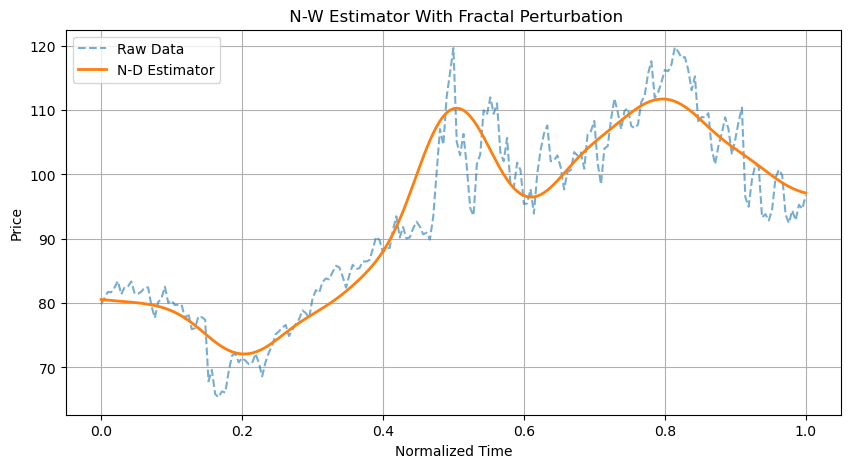

In [65]:
def plot_comparison_2(x_raw, w_raw, t_vals, u_hat_vals, coeffs):
    u_hat_interp = interp1d(t_vals, u_hat_vals, kind='linear', fill_value="extrapolate")
    xi_vals = xi_poly(x_raw, coeffs)
    f_vals = u_hat_interp(x_raw) - xi_vals

    plt.figure(figsize=(10, 5))
    plt.plot(x_raw, w_raw,'--', label='Raw Data', alpha=0.6)
    plt.plot(x_raw, f_vals, label='N-D Estimator', linewidth=2)
    plt.legend()
    plt.title(' N-W Estimator With Fractal Perturbation')
    plt.xlabel('Normalized Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()


plot_comparison_2(x_raw, w_raw, t_vals_1, u_hat_vals_1, optimal_coeffs_1)